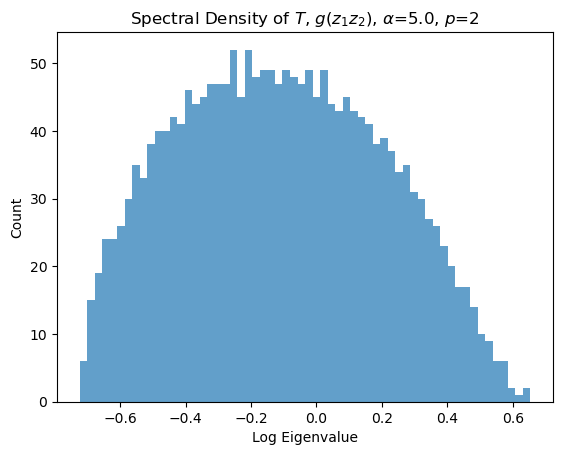

Subspace alignment score: 0.3598
Cosine similarity matrix:
 [[0.45  0.416]
 [0.416 0.414]]

[Individual Eigenvector Alignment Scores]
      Type       λ  Alignment Score
0  eig1992  3.7300           0.0955
1  eig1993  3.7693           0.0409
2  eig1994  3.7752           0.0655
3  eig1995  3.8706           0.0286
4  eig1996  3.9356           0.0651
5  eig1997  4.1131           0.2230
6  eig1998  4.4669           0.2047
7  eig1999  4.5050           0.3182

[Eigenvector Pair Subspace Alignment Scores]
               Type                  λ Pair  Alignment Score
0   eig1992+eig1993   (3.730026, 3.7692595)           0.1850
1   eig1992+eig1994   (3.730026, 3.7751896)           0.2128
2   eig1992+eig1995    (3.730026, 3.870582)           0.1821
3   eig1992+eig1996    (3.730026, 3.935615)           0.2167
4   eig1992+eig1997   (3.730026, 4.1131077)           0.4747
5   eig1992+eig1998   (3.730026, 4.4668584)           0.4399
6   eig1992+eig1999   (3.730026, 4.5050254)           0.6367
7   eig1

In [2]:
import torch
import numpy as np
import pandas as pd
from scipy.special import kv  # Bessel function Kν
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

# ========== Parameters ==========
n, d, p = 5000, 1000, 2
alpha = n / d
device = torch.device("cpu")

# ========== Step 1: Generate Data ==========
torch.manual_seed(0)
W_star = torch.nn.functional.normalize(torch.randn(d, p), dim=0)
X = torch.randn(n, d)
Z = X @ W_star
y = (Z[:, 0] * Z[:, 1]).numpy()  # scalar response

# ========== Step 2: Construct T(y) using Bessel approximation ==========
def construct_T_y(y_i):
    abs_y = np.abs(y_i) + 1e-8
    K0 = kv(0, abs_y)
    K1 = kv(1, abs_y)
    r = abs_y * (K1 / K0)
    return torch.tensor([[r, y_i], [y_i, r]], dtype=torch.float32)

I2 = torch.eye(2)
L_sym = torch.zeros((2*d, 2*d))  # 对称谱矩阵（原 T_hat）

for i in range(n):
    x_i = X[i].reshape(d, 1)
    kron_x = torch.kron(I2, x_i)  # (2d, 2)
    T_yi = construct_T_y(y[i])    # (2, 2)
    L_sym += kron_x @ T_yi @ kron_x.T

L_sym /= n

# ========== Step 3: Spectral Decomposition ==========
eigvals_sym, eigvecs_sym = torch.linalg.eigh(L_sym)
top_vals, indices = torch.topk(eigvals_sym, p)
U_top = eigvecs_sym[:, indices]  # (2d, p)

# ========== Step 4: Compute Subspace Alignment ==========
U_top_np = U_top.numpy()
U_top_reshaped = U_top_np.reshape(d, 2, p, order='F').sum(axis=1)  # (d, p)

W_np = W_star.numpy()
sim_matrix = cosine_similarity(U_top_reshaped.T, W_np.T)
subspace_score = np.linalg.norm(sim_matrix, 'fro')**2 / p

# ========== Step 5: Plot Spectrum ==========
plt.hist(np.log10(eigvals_sym.numpy()), bins=60, alpha=0.7)
plt.title(f"Spectral Density of $T$, $g(z_1z_2)$, $\\alpha$={alpha:.1f}, $p$={p}")
plt.xlabel("Log Eigenvalue")
plt.ylabel("Count")
plt.show()

print("Subspace alignment score:", round(subspace_score, 4))
print("Cosine similarity matrix:\n", np.round(sim_matrix, 3))

# ========== Step 6: Unified Evaluation ==========

def elevate_W_star_to_symmetric(W_star):
    return np.vstack([
        np.hstack([W_star, np.zeros_like(W_star)]),
        np.hstack([np.zeros_like(W_star), W_star])
    ])

def elevate_vector(v, position='top', d=None):
    if d is None:
        d = v.shape[0]
    if position == 'top':
        return np.concatenate([v, np.zeros(d)])
    else:
        return np.concatenate([np.zeros(d), v])

def evaluate_alignment_unified(eig_vals, eig_vecs, W_star, top_k=8, mode='symmetric'):
    d, p = W_star.shape
    W_sym_np = elevate_W_star_to_symmetric(W_star.numpy())
    W_sym = torch.tensor(W_sym_np, dtype=torch.float32)
    W_normed = W_sym / torch.norm(W_sym, dim=0, keepdim=True)

    indices = np.argsort(eig_vals)[-top_k:]

    individual_scores = []
    for i in indices:
        vec = eig_vecs[:, i]
        if mode == 'asymmetric':
            vec = elevate_vector(vec, position='top', d=d)
        vec_torch = torch.tensor(vec, dtype=torch.float32)
        vec_norm = vec_torch / torch.norm(vec_torch)
        cos_sim = torch.abs(torch.matmul(W_normed.T, vec_norm)).max().item()
        individual_scores.append((f"eig{i}", eig_vals[i], cos_sim))

    pair_scores = []
    for i, j in combinations(indices, 2):
        vi = eig_vecs[:, i]
        vj = eig_vecs[:, j]
        if mode == 'asymmetric':
            vi = elevate_vector(vi, 'top', d=d)
            vj = elevate_vector(vj, 'top', d=d)
        V = np.stack([vi, vj], axis=1)
        Q, _ = np.linalg.qr(V)
        Q_torch = torch.tensor(Q, dtype=torch.float32)
        proj = Q_torch @ Q_torch.T @ W_sym
        align_score = torch.norm(proj).item()
        pair_scores.append((f"eig{i}+eig{j}", (eig_vals[i], eig_vals[j]), align_score))

    individual_df = pd.DataFrame(individual_scores, columns=["Type", "λ", "Alignment Score"])
    pair_df = pd.DataFrame(pair_scores, columns=["Type", "λ Pair", "Alignment Score"])
    return individual_df, pair_df

# ========== Step 7: Run Unified Evaluation ==========
eigvals_np = eigvals_sym.numpy()
eigvecs_np = eigvecs_sym.numpy()

individual_df, pair_df = evaluate_alignment_unified(
    eigvals_np, eigvecs_np, W_star, top_k=8, mode='symmetric'
)

# ========== Optional: Display Results ==========
print("\n[Individual Eigenvector Alignment Scores]")
print(individual_df.round(4))

print("\n[Eigenvector Pair Subspace Alignment Scores]")
print(pair_df.round(4))


Subspace alignment score: 0.2691


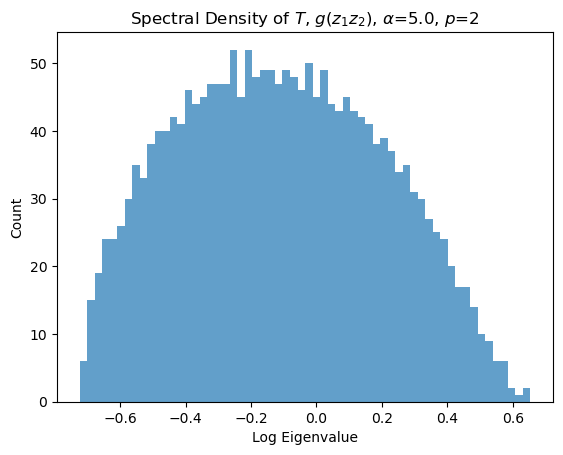

Subspace alignment score: 0.2691

[Individual Eigenvector Alignment Scores]
      Type       λ  Alignment Score
0  eig1992  3.7294           0.0957
1  eig1993  3.7686           0.0412
2  eig1994  3.7748           0.0653
3  eig1995  3.8698           0.0287
4  eig1996  3.9347           0.0648
5  eig1997  4.1118           0.2219
6  eig1998  4.4623           0.2060
7  eig1999  4.5044           0.3183

[Eigenvector Pair Subspace Alignment Scores]
               Type                  λ Pair  Alignment Score
0   eig1992+eig1993   (3.7294433, 3.768641)           0.0927
1   eig1992+eig1994   (3.7294433, 3.774835)           0.1064
2   eig1992+eig1995   (3.7294433, 3.869796)           0.0912
3   eig1992+eig1996  (3.7294433, 3.9346774)           0.1083
4   eig1992+eig1997   (3.7294433, 4.111814)           0.2363
5   eig1992+eig1998    (3.7294433, 4.46231)           0.2213
6   eig1992+eig1999   (3.7294433, 4.504375)           0.3185
7   eig1993+eig1994    (3.768641, 3.774835)           0.0686
8   e

In [47]:
import torch
import numpy as np
import pandas as pd
from scipy.special import kv  # Bessel function Kν
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

# ========== Parameters ==========
n, d, p = 5000, 1000, 2
alpha = n / d
device = torch.device("cpu")

# ========== Step 1: Generate Data ==========
torch.manual_seed(42)
W_star = torch.nn.functional.normalize(torch.randn(d, p), dim=0)
X = torch.randn(n, d)
Z = X @ W_star
scale = 2.0 
y = (Z[:, 0] * Z[:, 1]).numpy()  # scalar response

# ========== Step 2: Construct T(y) using Bessel approximation ==========
from scipy.special import kv  # Modified Bessel function of the second kind

def construct_T_y_adjustable(y_i, gamma=1.0, clip=1e-3, scale=1.0):
    """
    构造 Bessel-based T(y) 估计器，带可调参数：
        - gamma: 控制 y 项的比例系数
        - clip: r(y) 的最小值下界，避免数值不稳定
        - scale: 控制输入 y 的整体放大倍数
    
    参数:
        y_i: float, 标量响应值
        gamma: float, y 项缩放因子
        clip: float, 对 r 值下限裁剪
        scale: float, 对 y 进行放大（常用于控制谱图）
    
    返回:
        torch.tensor of shape (2, 2), 构造出的 T(y)
    """
    y_scaled = scale * y_i
    abs_y = np.abs(y_scaled) + 1e-8  # 避免 0 点溢出
    K0 = kv(0, abs_y)
    K1 = kv(1, abs_y)
    r = abs_y * (K1 / (K0 + 1e-6))
    r = np.clip(r, clip, None)

    return torch.tensor([
        [r, gamma * y_scaled],
        [gamma * y_scaled, r]
    ], dtype=torch.float32)


I2 = torch.eye(2)
L_sym = torch.zeros((2*d, 2*d))  # 对称谱矩阵（原 T_hat）

for i in range(n):
    x_i = X[i].reshape(d, 1)
    kron_x = torch.kron(I2, x_i)  # (2d, 2)
    T_yi = construct_T_y(y[i])    # (2, 2)
    L_sym += kron_x @ T_yi @ kron_x.T

L_sym /= n

# ========== Step 3: Spectral Decomposition ==========
eigvals_sym, eigvecs_sym = torch.linalg.eigh(L_sym)
top_vals, indices = torch.topk(eigvals_sym, p)
U_top = eigvecs_sym[:, indices]  # (2d, p)

# ========== Step 4: Compute Subspace Alignment ==========
U_top_np = U_top.numpy()  # shape (2d, p)，保留原格式
W_sym_np = elevate_W_star_to_symmetric(W_star.numpy())  # shape (2d, p)

# Subspace alignment score:
Q1, _ = np.linalg.qr(U_top_np)
Q2, _ = np.linalg.qr(W_sym_np)
overlap = Q1.T @ Q2
subspace_score = np.linalg.norm(overlap, 'fro')**2 / p

print("Subspace alignment score:", round(subspace_score, 4))

# ========== Step 5: Plot Spectrum ==========
plt.hist(np.log10(eigvals_sym.numpy()), bins=60, alpha=0.7)
plt.title(f"Spectral Density of $T$, $g(z_1z_2)$, $\\alpha$={alpha:.1f}, $p$={p}")
plt.xlabel("Log Eigenvalue")
plt.ylabel("Count")
plt.show()

print("Subspace alignment score:", round(subspace_score, 4))


# ========== Step 6: Unified Evaluation ==========

def elevate_W_star_to_symmetric(W_star):
    return np.vstack([
        np.hstack([W_star, np.zeros_like(W_star)]),
        np.hstack([np.zeros_like(W_star), W_star])
    ])

def elevate_vector(v, position='top', d=None):
    if d is None:
        d = v.shape[0]
    if position == 'top':
        return np.concatenate([v, np.zeros(d)])
    else:
        return np.concatenate([np.zeros(d), v])

def evaluate_alignment_unified(eig_vals, eig_vecs, W_star, top_k=8, mode='symmetric'):
    d, p = W_star.shape
    W_sym_np = elevate_W_star_to_symmetric(W_star.numpy())
    W_sym = torch.tensor(W_sym_np, dtype=torch.float32)
    W_normed = W_sym / torch.norm(W_sym, dim=0, keepdim=True)

    indices = np.argsort(eig_vals)[-top_k:]

    individual_scores = []
    for i in indices:
        vec = eig_vecs[:, i]
        if mode == 'asymmetric':
            vec = elevate_vector(vec, position='top', d=d)
        vec_torch = torch.tensor(vec, dtype=torch.float32)
        vec_norm = vec_torch / torch.norm(vec_torch)
        cos_sim = torch.abs(torch.matmul(W_normed.T, vec_norm)).max().item()
        individual_scores.append((f"eig{i}", eig_vals[i], cos_sim))

    pair_scores = []
    for i, j in combinations(indices, 2):
        vi = eig_vecs[:, i]
        vj = eig_vecs[:, j]
        if mode == 'asymmetric':
            vi = elevate_vector(vi, 'top', d=d)
            vj = elevate_vector(vj, 'top', d=d)
        V = np.stack([vi, vj], axis=1)
        Q, _ = np.linalg.qr(V)
        Q_torch = torch.tensor(Q, dtype=torch.float32)
        proj = Q_torch @ Q_torch.T @ W_sym
        align_score = (torch.norm(proj) / torch.norm(W_sym)).item()

        pair_scores.append((f"eig{i}+eig{j}", (eig_vals[i], eig_vals[j]), align_score))

    individual_df = pd.DataFrame(individual_scores, columns=["Type", "λ", "Alignment Score"])
    pair_df = pd.DataFrame(pair_scores, columns=["Type", "λ Pair", "Alignment Score"])
    return individual_df, pair_df

# ========== Step 7: Run Unified Evaluation ==========
eigvals_np = eigvals_sym.numpy()
eigvecs_np = eigvecs_sym.numpy()

individual_df, pair_df = evaluate_alignment_unified(
    eigvals_np, eigvecs_np, W_star, top_k=8, mode='symmetric'
)

# ========== Optional: Display Results ==========
print("\n[Individual Eigenvector Alignment Scores]")
print(individual_df.round(4))

print("\n[Eigenvector Pair Subspace Alignment Scores]")
print(pair_df.round(4))


Subspace alignment score: 0.5104


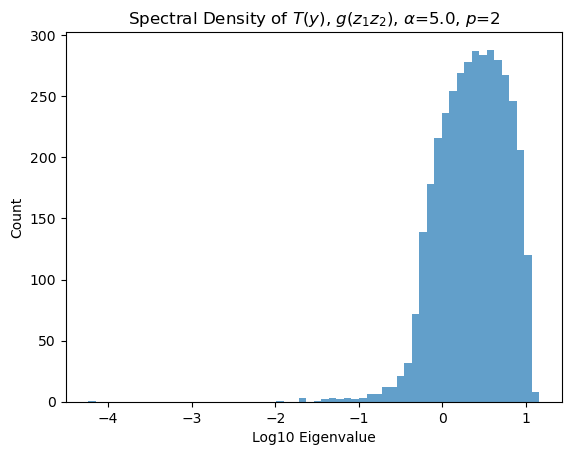


[Individual Eigenvector Alignment Scores]
      Type        λ  Alignment Score
0  eig3992  11.8022           0.0155
1  eig3993  11.8943           0.0062
2  eig3994  11.9445           0.0154
3  eig3995  12.1244           0.0422
4  eig3996  12.1480           0.0196
5  eig3997  12.6523           0.0506
6  eig3998  13.4327           0.3547
7  eig3999  14.4346           0.3646

[Eigenvector Pair Subspace Alignment Scores]
               Type                   λ Pair  Alignment Score
0   eig3992+eig3993  (11.802155, 11.8943405)           0.0144
1   eig3992+eig3994    (11.802155, 11.94452)           0.0193
2   eig3992+eig3995   (11.802155, 12.124382)           0.0380
3   eig3992+eig3996    (11.802155, 12.14804)           0.0209
4   eig3992+eig3997   (11.802155, 12.652277)           0.0485
5   eig3992+eig3998   (11.802155, 13.432653)           0.3506
6   eig3992+eig3999   (11.802155, 14.434556)           0.3643
7   eig3993+eig3994   (11.8943405, 11.94452)           0.0143
8   eig3993+eig3995 

In [85]:
import torch
import numpy as np
import pandas as pd
from scipy.special import kv  # Bessel function Kν
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

# ========== Parameters ==========
n, d, p = 10000, 2000, 2
alpha = n / d
device = torch.device("cpu")

# ========== Step 1: Generate Data ==========
torch.manual_seed(42)
W_star = torch.nn.functional.normalize(torch.randn(d, p), dim=0)
X = torch.randn(n, d)
Z = X @ W_star
y = (Z[:, 0] * Z[:, 1]).numpy()  # scalar response

# ========== Step 2: Construct T(y) using adjustable Bessel approximation ==========
def construct_T_y_adjustable(y_i, gamma=1, clip=1e-2, scale=5):
    y_scaled = scale * y_i
    abs_y = np.abs(y_scaled) + 1e-8
    K0 = kv(0, abs_y)
    K1 = kv(1, abs_y)
    r = abs_y * (K1 / (K0 + 1e-6))
    r = np.clip(r, clip, None)
    return torch.tensor([
        [r, gamma * y_scaled],
        [gamma * y_scaled, r]
    ], dtype=torch.float32)

# ========== Step 3: Construct Spectral Matrix ==========
I2 = torch.eye(2)
L_sym = torch.zeros((2*d, 2*d))

for i in range(n):
    x_i = X[i].reshape(d, 1)
    kron_x = torch.kron(I2, x_i)  # (2d, 2)
    T_yi = construct_T_y_adjustable(y[i], gamma=1, clip=1e-2, scale=5.0)
    L_sym += kron_x @ T_yi @ kron_x.T

L_sym /= n

# ========== Step 4: Spectral Decomposition ==========
eigvals_sym, eigvecs_sym = torch.linalg.eigh(L_sym)
top_vals, indices = torch.topk(eigvals_sym, p)
U_top = eigvecs_sym[:, indices]  # (2d, p)

# ========== Step 5: Subspace Alignment Score ==========
def elevate_W_star_to_symmetric(W_star):
    return np.vstack([
        np.hstack([W_star, np.zeros_like(W_star)]),
        np.hstack([np.zeros_like(W_star), W_star])
    ])

U_top_np = U_top.numpy()
W_sym_np = elevate_W_star_to_symmetric(W_star.numpy())
Q1, _ = np.linalg.qr(U_top_np)
Q2, _ = np.linalg.qr(W_sym_np)
overlap = Q1.T @ Q2
subspace_score = np.linalg.norm(overlap, 'fro')**2 / p

print("Subspace alignment score:", round(subspace_score, 4))

# ========== Step 6: Plot Spectrum ==========
eigvals_np = eigvals_sym.numpy()
eigvals_pos = eigvals_np[eigvals_np > 1e-12]  # 排除非正值（含 0）

plt.hist(np.log10(eigvals_pos), bins=60, alpha=0.7)
plt.title(f"Spectral Density of $T(y)$, $g(z_1z_2)$, $\\alpha$={alpha:.1f}, $p$={p}")
plt.xlabel("Log10 Eigenvalue")
plt.ylabel("Count")
plt.show()


# ========== Step 7: Unified Evaluation ==========

def elevate_vector(v, position='top', d=None):
    if d is None:
        d = v.shape[0]
    if position == 'top':
        return np.concatenate([v, np.zeros(d)])
    else:
        return np.concatenate([np.zeros(d), v])

def evaluate_alignment_unified(eig_vals, eig_vecs, W_star, top_k=8, mode='symmetric'):
    d, p = W_star.shape
    W_sym_np = elevate_W_star_to_symmetric(W_star.numpy())
    W_sym = torch.tensor(W_sym_np, dtype=torch.float32)
    W_normed = W_sym / torch.norm(W_sym, dim=0, keepdim=True)

    indices = np.argsort(eig_vals)[-top_k:]
    individual_scores = []

    for i in indices:
        vec = eig_vecs[:, i]
        if mode == 'asymmetric':
            vec = elevate_vector(vec, position='top', d=d)
        vec_torch = torch.tensor(vec, dtype=torch.float32)
        vec_norm = vec_torch / torch.norm(vec_torch)
        cos_sim = torch.abs(torch.matmul(W_normed.T, vec_norm)).max().item()
        individual_scores.append((f"eig{i}", eig_vals[i], cos_sim))

    pair_scores = []
    for i, j in combinations(indices, 2):
        vi = eig_vecs[:, i]
        vj = eig_vecs[:, j]
        if mode == 'asymmetric':
            vi = elevate_vector(vi, 'top', d=d)
            vj = elevate_vector(vj, 'top', d=d)
        V = np.stack([vi, vj], axis=1)
        Q, _ = np.linalg.qr(V)
        Q_torch = torch.tensor(Q, dtype=torch.float32)
        proj = Q_torch @ Q_torch.T @ W_sym
        align_score = (torch.norm(proj) / torch.norm(W_sym)).item()
        pair_scores.append((f"eig{i}+eig{j}", (eig_vals[i], eig_vals[j]), align_score))

    individual_df = pd.DataFrame(individual_scores, columns=["Type", "λ", "Alignment Score"])
    pair_df = pd.DataFrame(pair_scores, columns=["Type", "λ Pair", "Alignment Score"])
    return individual_df, pair_df

# ========== Step 8: Run Unified Evaluation ==========
eigvals_np = eigvals_sym.numpy()
eigvecs_np = eigvecs_sym.numpy()

individual_df, pair_df = evaluate_alignment_unified(
    eigvals_np, eigvecs_np, W_star, top_k=8, mode='symmetric'
)

print("\n[Individual Eigenvector Alignment Scores]")
print(individual_df.round(4))

print("\n[Eigenvector Pair Subspace Alignment Scores]")
print(pair_df.round(4))


Subspace alignment score: 0.5104


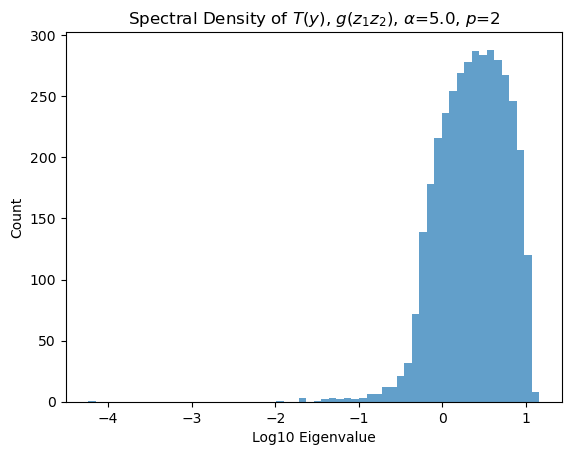


[Individual Eigenvector Alignment Scores]
      Type        λ  Alignment Score
0  eig3992  11.8022           0.0155
1  eig3993  11.8943           0.0062
2  eig3994  11.9445           0.0154
3  eig3995  12.1244           0.0422
4  eig3996  12.1480           0.0196
5  eig3997  12.6523           0.0506
6  eig3998  13.4327           0.3547
7  eig3999  14.4346           0.3646

[Eigenvector Pair Subspace Alignment Scores]
               Type                   λ Pair  Alignment Score
0   eig3992+eig3993  (11.802155, 11.8943405)           0.0144
1   eig3992+eig3994    (11.802155, 11.94452)           0.0193
2   eig3992+eig3995   (11.802155, 12.124382)           0.0380
3   eig3992+eig3996    (11.802155, 12.14804)           0.0209
4   eig3992+eig3997   (11.802155, 12.652277)           0.0485
5   eig3992+eig3998   (11.802155, 13.432653)           0.3506
6   eig3992+eig3999   (11.802155, 14.434556)           0.3643
7   eig3993+eig3994   (11.8943405, 11.94452)           0.0143
8   eig3993+eig3995 

In [95]:
import torch
import numpy as np
import pandas as pd
from scipy.special import kv  # Bessel function Kν
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

# ========== Parameters ==========
n, d, p = 10000, 2000, 2
alpha = n / d
device = torch.device("cpu")

# ========== Step 1: Generate Data ==========
torch.manual_seed(42)
W_star = torch.nn.functional.normalize(torch.randn(d, p), dim=0)
X = torch.randn(n, d)
Z = X @ W_star
y = (Z[:, 0] * Z[:, 1]).numpy()  # scalar response

# ========== Step 2: Construct T(y) using adjustable Bessel approximation ==========
def construct_T_y_full_enhanced(y_i, gamma=1.0, beta=0.1, clip=1e-2, scale=5.0):
    """
    最全面增强版本 T(y)，融合 r(y), βy², tanh(y)

    参数：
        y_i: 单个响应
        gamma: 非对角项系数
        beta: 对角项中 y² 项系数
        clip: 对 r(y) 的裁剪
        scale: y 缩放因子
    
    返回：
        2×2 torch.tensor
    """
    y_scaled = scale * y_i
    abs_y = np.abs(y_scaled) + 1e-8

    K0 = kv(0, abs_y)
    K1 = kv(1, abs_y)
    r = abs_y * (K1 / (K0 + 1e-6))
    r = np.clip(r, clip, None)

    diag = r + beta * (y_scaled ** 2)
    off = gamma * np.tanh(y_scaled)

    return torch.tensor([
        [diag, off],
        [off, diag]
    ], dtype=torch.float32)



# ========== Step 3: Construct Spectral Matrix ==========
I2 = torch.eye(2)
L_sym = torch.zeros((2*d, 2*d))

for i in range(n):
    x_i = X[i].reshape(d, 1)
    kron_x = torch.kron(I2, x_i)  # (2d, 2)
    T_yi = construct_T_y_adjustable(y[i], gamma=1, clip=1e-2, scale=5.0)
    L_sym += kron_x @ T_yi @ kron_x.T

L_sym /= n

# ========== Step 4: Spectral Decomposition ==========
eigvals_sym, eigvecs_sym = torch.linalg.eigh(L_sym)
top_vals, indices = torch.topk(eigvals_sym, p)
U_top = eigvecs_sym[:, indices]  # (2d, p)

# ========== Step 5: Subspace Alignment Score ==========
def elevate_W_star_to_symmetric(W_star):
    return np.vstack([
        np.hstack([W_star, np.zeros_like(W_star)]),
        np.hstack([np.zeros_like(W_star), W_star])
    ])

U_top_np = U_top.numpy()
W_sym_np = elevate_W_star_to_symmetric(W_star.numpy())
Q1, _ = np.linalg.qr(U_top_np)
Q2, _ = np.linalg.qr(W_sym_np)
overlap = Q1.T @ Q2
subspace_score = np.linalg.norm(overlap, 'fro')**2 / p

print("Subspace alignment score:", round(subspace_score, 4))

# ========== Step 6: Plot Spectrum ==========
eigvals_np = eigvals_sym.numpy()
eigvals_pos = eigvals_np[eigvals_np > 1e-12]  # 排除非正值（含 0）

plt.hist(np.log10(eigvals_pos), bins=60, alpha=0.7)
plt.title(f"Spectral Density of $T(y)$, $g(z_1z_2)$, $\\alpha$={alpha:.1f}, $p$={p}")
plt.xlabel("Log10 Eigenvalue")
plt.ylabel("Count")
plt.show()


# ========== Step 7: Unified Evaluation ==========

def elevate_vector(v, position='top', d=None):
    if d is None:
        d = v.shape[0]
    if position == 'top':
        return np.concatenate([v, np.zeros(d)])
    else:
        return np.concatenate([np.zeros(d), v])

def evaluate_alignment_unified(eig_vals, eig_vecs, W_star, top_k=8, mode='symmetric'):
    d, p = W_star.shape
    W_sym_np = elevate_W_star_to_symmetric(W_star.numpy())
    W_sym = torch.tensor(W_sym_np, dtype=torch.float32)
    W_normed = W_sym / torch.norm(W_sym, dim=0, keepdim=True)

    indices = np.argsort(eig_vals)[-top_k:]
    individual_scores = []

    for i in indices:
        vec = eig_vecs[:, i]
        if mode == 'asymmetric':
            vec = elevate_vector(vec, position='top', d=d)
        vec_torch = torch.tensor(vec, dtype=torch.float32)
        vec_norm = vec_torch / torch.norm(vec_torch)
        cos_sim = torch.abs(torch.matmul(W_normed.T, vec_norm)).max().item()
        individual_scores.append((f"eig{i}", eig_vals[i], cos_sim))

    pair_scores = []
    for i, j in combinations(indices, 2):
        vi = eig_vecs[:, i]
        vj = eig_vecs[:, j]
        if mode == 'asymmetric':
            vi = elevate_vector(vi, 'top', d=d)
            vj = elevate_vector(vj, 'top', d=d)
        V = np.stack([vi, vj], axis=1)
        Q, _ = np.linalg.qr(V)
        Q_torch = torch.tensor(Q, dtype=torch.float32)
        proj = Q_torch @ Q_torch.T @ W_sym
        align_score = (torch.norm(proj) / torch.norm(W_sym)).item()
        pair_scores.append((f"eig{i}+eig{j}", (eig_vals[i], eig_vals[j]), align_score))

    individual_df = pd.DataFrame(individual_scores, columns=["Type", "λ", "Alignment Score"])
    pair_df = pd.DataFrame(pair_scores, columns=["Type", "λ Pair", "Alignment Score"])
    return individual_df, pair_df

# ========== Step 8: Run Unified Evaluation ==========
eigvals_np = eigvals_sym.numpy()
eigvecs_np = eigvecs_sym.numpy()

individual_df, pair_df = evaluate_alignment_unified(
    eigvals_np, eigvecs_np, W_star, top_k=8, mode='symmetric'
)

print("\n[Individual Eigenvector Alignment Scores]")
print(individual_df.round(4))

print("\n[Eigenvector Pair Subspace Alignment Scores]")
print(pair_df.round(4))


In [5]:
import torch
import numpy as np
import pandas as pd
from scipy.special import kv  # Bessel function Kν
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

# ========== Parameters ==========
n, d, p = 10000, 2000, 2
alpha = n / d
device = torch.device("cpu")

# ========== Step 1: Generate Data ==========
torch.manual_seed(42)
W_star = torch.nn.functional.normalize(torch.randn(d, p), dim=0)
X = torch.randn(n, d)
Z = X @ W_star
y = (Z[:, 0] * Z[:, 1]).numpy()  # scalar response

# ========== Step 2: Construct T(y) using adjustable Bessel approximation ==========
def construct_T_y_adjustable(y_i, gamma=1.0, beta=0.1, clip=1e-2, scale=5.0):
    """
    最全面增强版本 T(y)，融合 r(y), βy², tanh(y)

    参数：
        y_i: 单个响应
        gamma: 非对角项系数
        beta: 对角项中 y² 项系数
        clip: 对 r(y) 的裁剪
        scale: y 缩放因子
    
    返回：
        2×2 torch.tensor
    """
    y_scaled = scale * y_i
    abs_y = np.abs(y_scaled) + 1e-8

    K0 = kv(0, abs_y)
    K1 = kv(1, abs_y)
    r = abs_y * (K1 / (K0 + 1e-6))
    r = np.clip(r, clip, None)

    return torch.tensor([
        [diag, off],
        [off, diag]
    ], dtype=torch.float32)



# ========== Step 3: Construct Spectral Matrix ==========
I2 = torch.eye(2)
L_sym = torch.zeros((2*d, 2*d))

for i in range(n):
    x_i = X[i].reshape(d, 1)
    kron_x = torch.kron(I2, x_i)  # (2d, 2)
    T_yi = construct_T_y_adjustable(y[i], gamma=1, clip=1e-2, scale=5.0)
    L_sym += kron_x @ T_yi @ kron_x.T

L_sym /= n

# ========== Step 4: Spectral Decomposition ==========
eigvals_sym, eigvecs_sym = torch.linalg.eigh(L_sym)
top_vals, indices = torch.topk(eigvals_sym, p)
U_top = eigvecs_sym[:, indices]  # (2d, p)

# ========== Step 5: Subspace Alignment Score ==========
def elevate_W_star_to_symmetric(W_star):
    return np.vstack([
        np.hstack([W_star, np.zeros_like(W_star)]),
        np.hstack([np.zeros_like(W_star), W_star])
    ])

U_top_np = U_top.numpy()
W_sym_np = elevate_W_star_to_symmetric(W_star.numpy())
Q1, _ = np.linalg.qr(U_top_np)
Q2, _ = np.linalg.qr(W_sym_np)
overlap = Q1.T @ Q2
subspace_score = np.linalg.norm(overlap, 'fro')**2 / p

print("Subspace alignment score:", round(subspace_score, 4))

# ========== Step 6: Plot Spectrum ==========
eigvals_np = eigvals_sym.numpy()
eigvals_pos = eigvals_np[eigvals_np > 1e-12]  # 排除非正值（含 0）

plt.hist(np.log10(eigvals_pos), bins=60, alpha=0.7)
plt.title(f"Spectral Density of $T(y)$, $g(z_1z_2)$, $\\alpha$={alpha:.1f}, $p$={p}")
plt.xlabel("Log10 Eigenvalue")
plt.ylabel("Count")
plt.show()


# ========== Step 7: Unified Evaluation ==========

def elevate_vector(v, position='top', d=None):
    if d is None:
        d = v.shape[0]
    if position == 'top':
        return np.concatenate([v, np.zeros(d)])
    else:
        return np.concatenate([np.zeros(d), v])

def evaluate_alignment_unified(eig_vals, eig_vecs, W_star, top_k=8, mode='symmetric'):
    d, p = W_star.shape
    W_sym_np = elevate_W_star_to_symmetric(W_star.numpy())
    W_sym = torch.tensor(W_sym_np, dtype=torch.float32)
    W_normed = W_sym / torch.norm(W_sym, dim=0, keepdim=True)

    indices = np.argsort(eig_vals)[-top_k:]
    individual_scores = []

    for i in indices:
        vec = eig_vecs[:, i]
        if mode == 'asymmetric':
            vec = elevate_vector(vec, position='top', d=d)
        vec_torch = torch.tensor(vec, dtype=torch.float32)
        vec_norm = vec_torch / torch.norm(vec_torch)
        cos_sim = torch.abs(torch.matmul(W_normed.T, vec_norm)).max().item()
        individual_scores.append((f"eig{i}", eig_vals[i], cos_sim))

    pair_scores = []
    for i, j in combinations(indices, 2):
        vi = eig_vecs[:, i]
        vj = eig_vecs[:, j]
        if mode == 'asymmetric':
            vi = elevate_vector(vi, 'top', d=d)
            vj = elevate_vector(vj, 'top', d=d)
        V = np.stack([vi, vj], axis=1)
        Q, _ = np.linalg.qr(V)
        Q_torch = torch.tensor(Q, dtype=torch.float32)
        proj = Q_torch @ Q_torch.T @ W_sym
        align_score = (torch.norm(proj) / torch.norm(W_sym)).item()
        pair_scores.append((f"eig{i}+eig{j}", (eig_vals[i], eig_vals[j]), align_score))

    individual_df = pd.DataFrame(individual_scores, columns=["Type", "λ", "Alignment Score"])
    pair_df = pd.DataFrame(pair_scores, columns=["Type", "λ Pair", "Alignment Score"])
    return individual_df, pair_df

# ========== Step 8: Run Unified Evaluation ==========
eigvals_np = eigvals_sym.numpy()
eigvecs_np = eigvecs_sym.numpy()

individual_df, pair_df = evaluate_alignment_unified(
    eigvals_np, eigvecs_np, W_star, top_k=8, mode='symmetric'
)

print("\n[Individual Eigenvector Alignment Scores]")
print(individual_df.round(4))

print("\n[Eigenvector Pair Subspace Alignment Scores]")
print(pair_df.round(4))


NameError: name 'diag' is not defined